In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering

In [2]:
%matplotlib inline

In [3]:
sns.set(style="ticks", color_codes=True)

In [4]:
df = gpd.read_file('outputs/newvars_surveys.geojson')

In [5]:
df.columns

Index(['latitude', 'longitude', 'venta_frutas', 'venta_verduras',
       'superficie_bodega', 'num_personas', 'hora_apertura_semana',
       'hora_cierre_semana', 'abre_fin_de_semana', 'horario_atencion_igual',
       'hora_apertura_fin_de_semana', 'hora_cierre_fin_de_semana',
       'num_entregas_general', 'num_recojos_general', 'num_lugares',
       'num_entregas_fv', 'num_recojos_fv', 'lugar_principal',
       'vehiculo_recojo', 'vehiculo_recojo_other',
       'num_viajes_lugar_principal', 'cant_carga', 'cant_sku', 'cadena_frio',
       'cant_merma', 'motivo_si_oferta', 'motivo_si_oferta_other',
       'motivo_no_oferta', 'motivo_no_oferta_other', 'gps_altitude',
       'ventaFyV', 'in_food_desert', 'distrito', 'distance_to_market',
       'dist_2closest_mkt', 'NSE07', 'index_right', 'population',
       'betweenness_centrality_avg', 'kopt+0_Clusters', 'geometry'],
      dtype='object')

In [6]:
df.distrito.value_counts()

VILLA EL SALVADOR         112
SAN JUAN DE LURIGANCHO    105
SURQUILLO                 101
SAN MIGUEL                 84
BARRANCO                   50
SANTIAGO DE SURCO          50
SAN ISIDRO                 46
ATE                        37
LA MOLINA                  13
CHORRILLOS                  9
PUEBLO LIBRE                5
LINCE                       4
MAGDALENA DEL MAR           3
Name: distrito, dtype: int64

In [7]:
sel_vars = ['superficie_bodega', 'num_personas', 'atencion_semana',
            'atencion_fin_de_semana', 'num_entregas_general',
            'num_recojos_general', 'NSE07',
            'population', 'betweenness_centrality_avg', 'kopt+0_Clusters']

In [8]:
X = df[sel_vars]

KeyError: "['atencion_semana', 'atencion_fin_de_semana'] not in index"

In [10]:
X.shape

(619, 10)

In [11]:
X.isna().sum()

superficie_bodega              47
num_personas                  212
atencion_semana               234
atencion_fin_de_semana        237
num_entregas_general           37
num_recojos_general            60
NSE07                           0
population                      0
betweenness_centrality_avg      0
kopt+0_Clusters                 0
dtype: int64

In [12]:
X.dtypes

superficie_bodega             float64
num_personas                  float64
atencion_semana               float64
atencion_fin_de_semana        float64
num_entregas_general          float64
num_recojos_general           float64
NSE07                          object
population                    float64
betweenness_centrality_avg    float64
kopt+0_Clusters                object
dtype: object

In [13]:
numeric_features = X.select_dtypes(include=['int64','float64']).columns

In [14]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', Normalizer())])

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('nse', OrdinalEncoder(), ['NSE07']),
        ('clusters_log', OneHotEncoder(handle_unknown='ignore'), ['kopt+0_Clusters'])    
    ]
)

In [16]:
datapipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
])

In [17]:
dbs = []
chs = []
ss = []

n_cluster_options = range(2, 16)

for n_cluster in n_cluster_options:
    kmeans = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clustering', KMeans(n_cluster, random_state=0))
    ])
    kmeans.fit(X)
    
    data_transformed = datapipe.transform(X)

    dbs.append(davies_bouldin_score(data_transformed, kmeans[1].labels_))
    chs.append(calinski_harabasz_score(data_transformed, kmeans[1].labels_))
    ss.append(silhouette_score(data_transformed, kmeans[1].labels_))

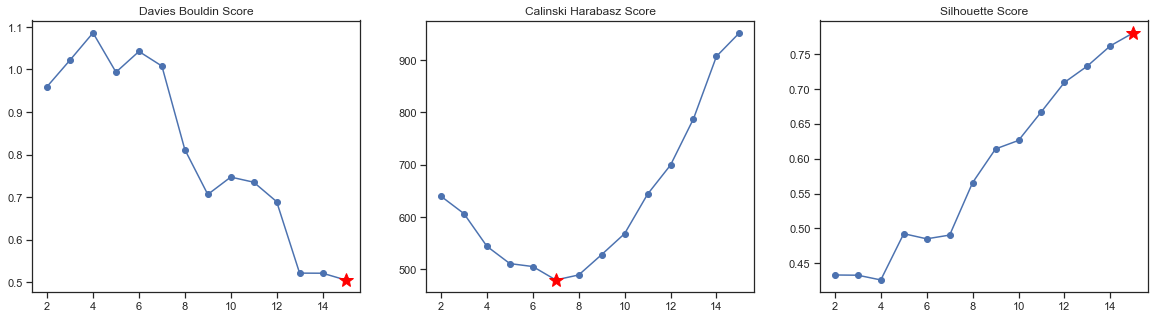

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

# The minimum score is zero, with lower values indicating better clustering.
ax1.set_title("Davies Bouldin Score")
ax1.plot(n_cluster_options, dbs, marker='o')
ax1.plot(dbs.index(np.min(dbs))+2, np.min(dbs), marker='*', color='red', markersize=15)

# Ratio between the within-cluster dispersion and the between-cluster dispersion (the lower the better).
ax2.set_title("Calinski Harabasz Score")
ax2.plot(n_cluster_options, chs, marker='o')
ax2.plot(chs.index(np.min(chs))+2, np.min(chs), marker='*', color='red', markersize=15)

# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
ax3.set_title("Silhouette Score")
ax3.plot(n_cluster_options, ss, marker='o')
ax3.plot(ss.index(np.max(ss))+2, np.max(ss), marker='*', color='red', markersize=15)

plt.savefig("outputs/clusters_eval_1.png")
plt.show()

In [19]:
N_CLUSTERS = 7

In [20]:
kmeans = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clustering', KMeans(N_CLUSTERS, random_state=0))
])
kmeans.fit(X)
df['kmeans_clusters'] = kmeans[1].labels_

In [21]:
df.groupby(by=['kmeans_clusters']).count().iloc[:,0]

kmeans_clusters
0     84
1     46
2     70
3    135
4     93
5     48
6    143
Name: latitude, dtype: int64

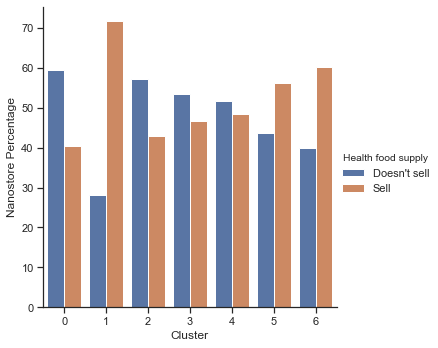

In [23]:
vyf_by_cluster = (df.groupby(by=['kmeans_clusters', 'venta_bool']).count().iloc[:,0] / df.groupby(by=['kmeans_clusters']).count().iloc[:,0])*100
vyf_by_cluster.name = 'Nanostore Percentage'
vyf_by_cluster = vyf_by_cluster.reset_index()
vyf_by_cluster.columns = ["Cluster", "Health food supply", 'Nanostore Percentage']
vyf_by_cluster["Health food supply"] = vyf_by_cluster["Health food supply"].replace(to_replace={"No vende frutas ni verduras": "Doesn't sell",
                                                                                                "Vende frutas y verduras": "Sell"})
sns.catplot(x="Cluster", y="Nanostore Percentage", hue="Health food supply", kind="bar", data=vyf_by_cluster);
plt.savefig('outputs/barchart_clusters.png')

In [24]:
vyf_by_cluster

,Cluster,Health food supply,Nanostore Percentage
0,0,Doesn't sell,59.523810
1,0,Sell,40.476190
2,1,Doesn't sell,28.260870
3,1,Sell,71.739130
4,2,Doesn't sell,57.142857
5,2,Sell,42.857143
6,3,Doesn't sell,53.333333
7,3,Sell,46.666667
8,4,Doesn't sell,51.612903
9,4,Sell,48.387097


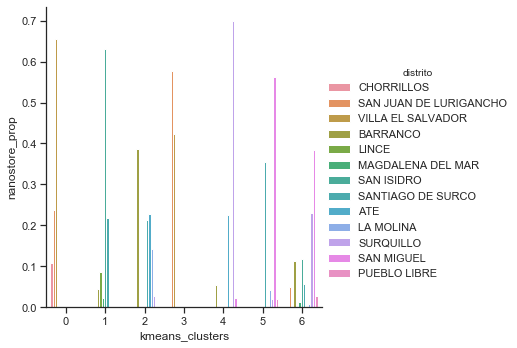

In [25]:
distrito_by_cluster = df.groupby(by=['kmeans_clusters', 'distrito']).count().iloc[:,0] / df.groupby(by=['kmeans_clusters']).count().iloc[:,0]
distrito_by_cluster.name = 'nanostore_prop'
distrito_by_cluster = distrito_by_cluster.reset_index()

sns.catplot(x="kmeans_clusters", y="nanostore_prop", hue="distrito", kind="bar", data=distrito_by_cluster);
plt.savefig('outputs/barchart_clusters.png')

In [26]:
cluster_comparation_num_vars = ['superficie_bodega', 'num_entregas_general',
                                'num_recojos_general', 'distance_to_market', 
                                'population', 'betweenness_centrality_avg',
                                'dist_2closest_mkt']

centroids = df.groupby('kmeans_clusters').mean()[cluster_comparation_num_vars]

In [27]:
df.groupby('kmeans_clusters').mean()[cluster_comparation_num_vars].to_csv("outputs/cluster_centroids_means_1.csv")

In [28]:
pd.DataFrame(df[cluster_comparation_num_vars].mean()).T

,superficie_bodega,num_entregas_general,num_recojos_general,distance_to_market,population,betweenness_centrality_avg,dist_2closest_mkt
0,16.291958,4.231959,1.801431,9218.031733,16058.082391,0.061814,622.50026


In [29]:
centroids

,superficie_bodega,num_entregas_general,num_recojos_general,distance_to_market,population,betweenness_centrality_avg,dist_2closest_mkt
kmeans_clusters,,,,,,,
0,10.605263,3.320988,2.282051,7933.645750,4635.976190,0.107002,1446.897767
1,35.326087,6.044444,1.555556,11509.145772,26701.717391,0.061363,900.744532
2,20.785714,2.333333,1.478261,10674.770407,12678.128571,0.057961,305.834651
3,8.840909,4.216418,1.514925,6101.057151,13353.170370,0.047726,600.499190
4,12.483871,2.534091,2.090909,10097.557566,23272.161290,0.057850,189.420688
5,38.064516,9.833333,2.028571,10174.574797,11729.958333,0.054176,750.637608
6,15.524194,4.552846,1.809091,10192.901326,20312.979021,0.055742,463.157024


In [30]:
# Standarize variables to compare in radar plot
centroids = ( centroids - centroids.mean() ) / centroids.std()

In [31]:
centroids.columns

Index(['superficie_bodega', 'num_entregas_general', 'num_recojos_general',
       'distance_to_market', 'population', 'betweenness_centrality_avg',
       'dist_2closest_mkt'],
      dtype='object')

In [32]:
centroids

,superficie_bodega,num_entregas_general,num_recojos_general,distance_to_market,population,betweenness_centrality_avg,dist_2closest_mkt
kmeans_clusters,,,,,,,
0,-0.808523,-0.526535,1.440152,-0.857205,-1.497787,2.215340,1.847051
1,1.267508,0.520336,-0.837877,1.067293,1.385697,-0.088553,0.556375
2,0.046422,-0.906179,-1.080245,0.618194,-0.446863,-0.260262,-0.849524
3,-0.956692,-0.182340,-0.965278,-1.843589,-0.358650,-0.776947,-0.153169
4,-0.650759,-0.829010,0.840799,0.307512,0.937533,-0.265915,-1.124635
5,1.497479,1.976748,0.645331,0.348966,-0.570767,-0.451338,0.201640
6,-0.395436,-0.053020,-0.042881,0.358830,0.550836,-0.372325,-0.477738


In [33]:
centroids.columns = ['Nanostore size', 
                     'Delivers\ncount', 'Pick ups\ncount',
                     'Distance to\npreferred market', 'Population density',
                     'Accesibility', 'Distance to\nclosest market']

In [34]:
centroids.values

array([[-0.80852275, -0.5265346 ,  1.44015197, -0.85720547, -1.49778651,
         2.21534029,  1.84705133],
       [ 1.26750831,  0.52033595, -0.83787676,  1.0672933 ,  1.38569693,
        -0.08855332,  0.55637476],
       [ 0.04642176, -0.9061794 , -1.08024504,  0.61819405, -0.44686268,
        -0.26026163, -0.84952416],
       [-0.95669151, -0.18233984, -0.96527837, -1.84358905, -0.35865029,
        -0.77694696, -0.15316901],
       [-0.65075907, -0.82901013,  0.84079896,  0.30751152,  0.93753305,
        -0.2659149 , -1.12463518],
       [ 1.49747896,  1.97674833,  0.64533052,  0.34896574, -0.57076667,
        -0.45133806,  0.20164009],
       [-0.3954357 , -0.0530203 , -0.04288128,  0.35882992,  0.55083618,
        -0.37232543, -0.47773784]])

In [77]:
def make_spider(row, title, color):

    # number of variable
    categories = list(centroids)
    N = len(categories)

    values = centroids.loc[0].values.flatten().tolist()
    values += values[:1]

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the spider plot
    ax = plt.subplot(4,2,row+1, polar=True)
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw one axe per variable + add labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    
    # We are going to plot the first given row of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values = centroids.loc[row].values.flatten().tolist()
    values += values[:1]
    
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.set_rlim(-2.5,2.5)
    ax.set_rticks([-2, -1, 0, 1, 2])
    ax.set_rlabel_position(-22.5)
    ax.grid(True)
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

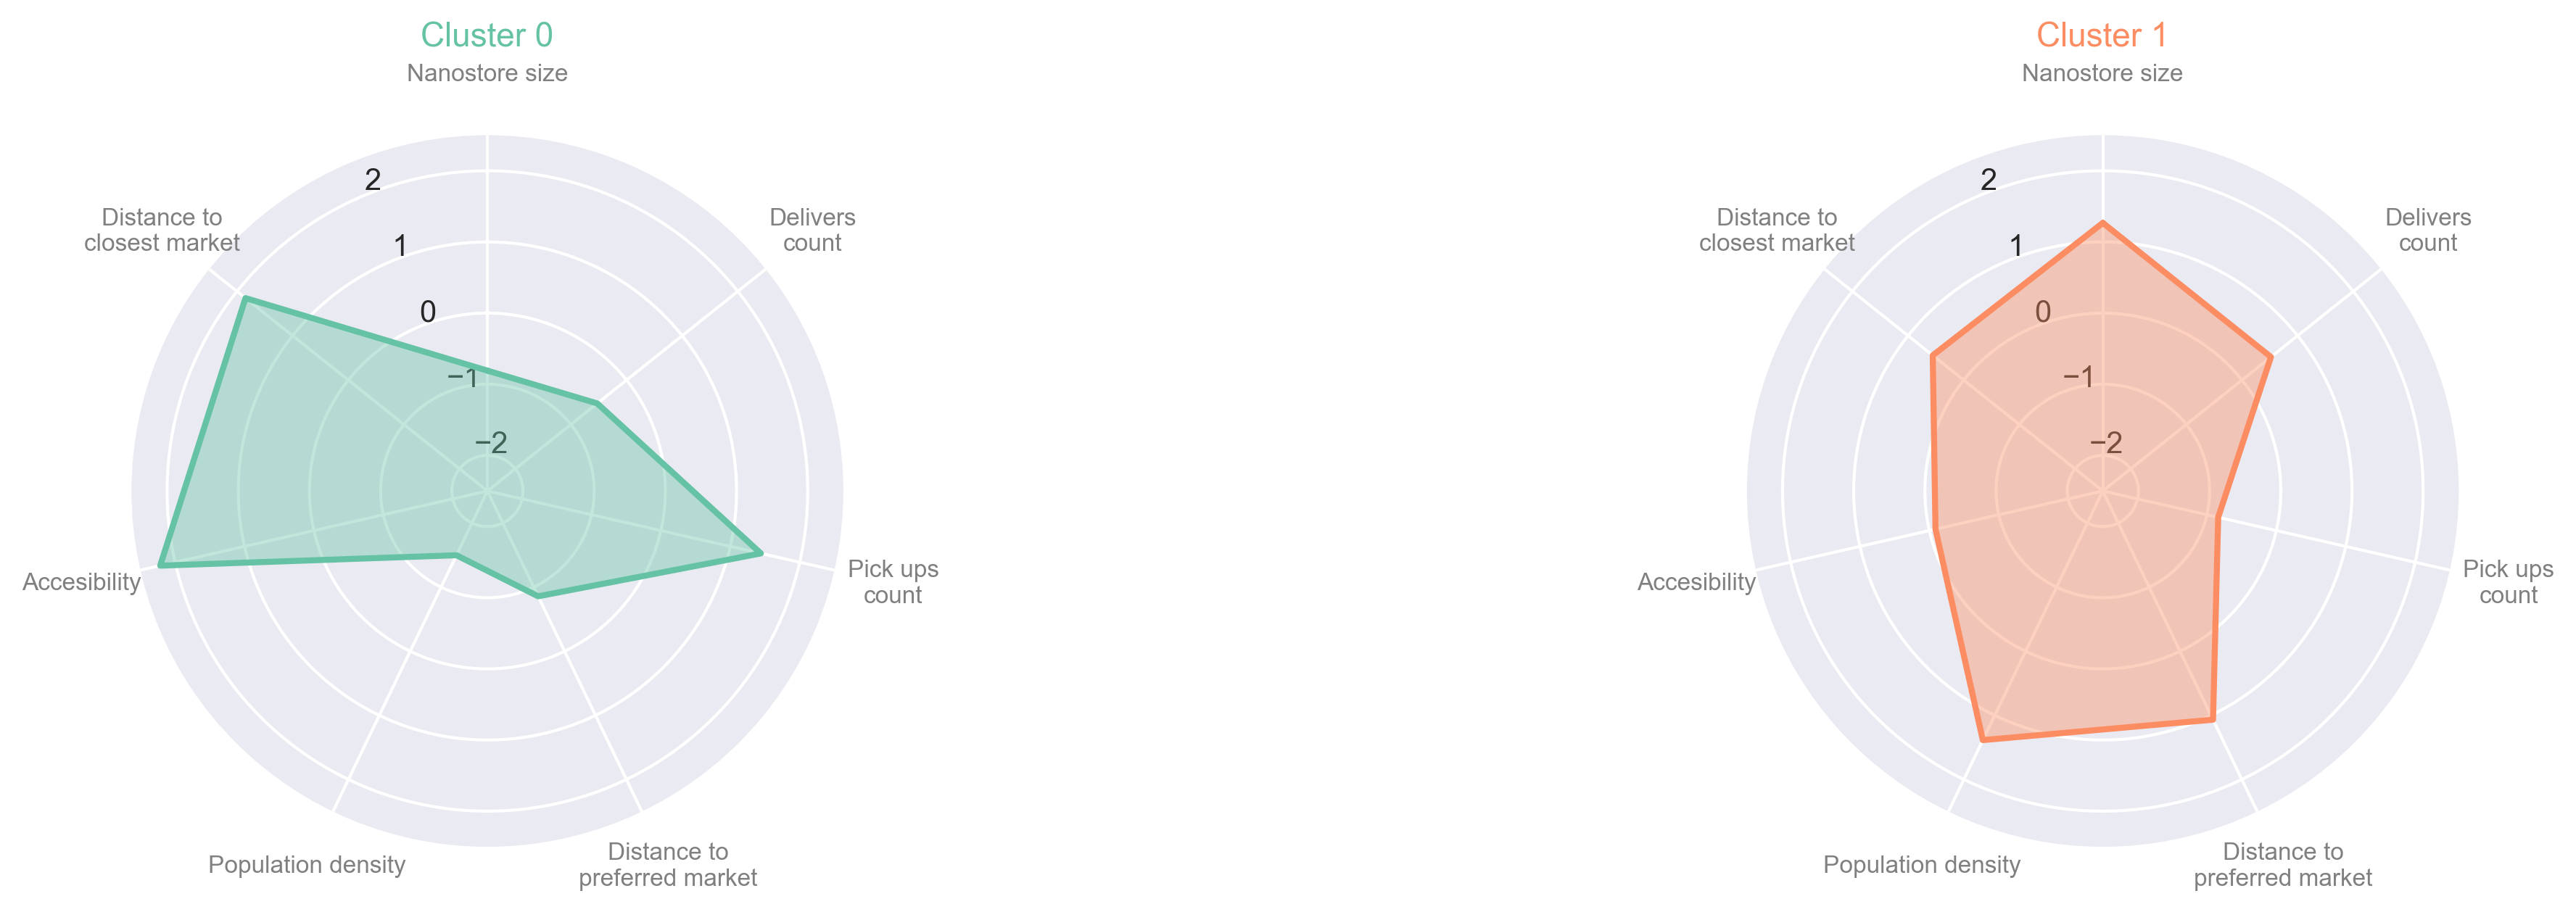

In [78]:
# initialize the figure
my_dpi=300
plt.figure(figsize=(15, 15), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(centroids.index))

# Loop to plot
for row in range(0, 2):
    make_spider(row = row, title = 'Cluster ' + str(row),
                color = my_palette(row))

plt.tight_layout()
plt.savefig('outputs/radarchart_clusters_1.png')

In [66]:
import mplleaflet as leaflet

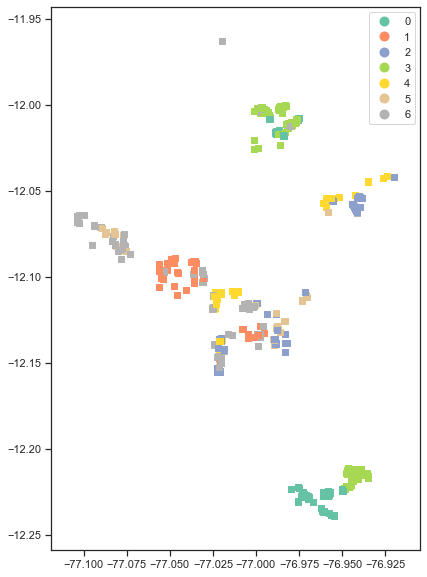

In [68]:
df.plot(cmap='Set2', column='kmeans_clusters', figsize=(10,10), marker='s', categorical=True, legend=True, )

In [69]:
df.plot(cmap='Set2', column='kmeans_clusters', figsize=(10,10), marker='s', categorical=True)
leaflet.display()

/Users/cortega/Documents/food_deserts/.env/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [70]:
df

,latitude,longitude,venta_frutas,venta_verduras,superficie_bodega,num_personas,hora_apertura_semana,hora_cierre_semana,abre_fin_de_semana,horario_atencion_igual,...,distrito,distance_to_market,dist_2closest_mkt,NSE07,index_right,population,betweenness_centrality_avg,kopt+0_Clusters,geometry,kmeans_clusters
0,-11.962990,-77.019870,1.0,1.0,9.0,NaN,None,None,None,None,...,SAN JUAN DE LURIGANCHO,12230.422450,1127.519607,BA,485.0,16916.0,0.074221,1.0,POINT (-77.01987 -11.96299),6
1,-12.008620,-76.976800,1.0,1.0,9.0,NaN,None,None,None,None,...,SAN JUAN DE LURIGANCHO,9876.823238,1244.469289,ME,394.0,14704.0,0.064132,4.0,POINT (-76.9768 -12.00862),3
2,-12.009120,-76.976290,1.0,1.0,16.0,NaN,None,None,None,None,...,SAN JUAN DE LURIGANCHO,9877.846700,1243.880937,ME,394.0,14704.0,0.064132,4.0,POINT (-76.97629000000001 -12.00912),3
3,-12.007590,-76.975020,0.0,0.0,9.0,NaN,None,None,None,None,...,SAN JUAN DE LURIGANCHO,NaN,1431.075633,ME,NaN,8576.0,0.135574,1.0,POINT (-76.97502 -12.00759),0
4,-12.223180,-76.979340,1.0,1.0,6.0,NaN,None,None,None,None,...,CHORRILLOS,4232.258826,2204.734733,ME,NaN,1423.0,0.143672,1.0,POINT (-76.97933999999999 -12.22318),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,-12.002385,-76.986793,0.0,0.0,6.0,1.0,None,None,None,None,...,SAN JUAN DE LURIGANCHO,NaN,1248.690035,MB,416.0,14273.0,0.056376,4.0,POINT (-76.9867927 -12.0023846),3
615,-12.002580,-76.986527,0.0,0.0,4.0,1.0,None,None,None,None,...,SAN JUAN DE LURIGANCHO,NaN,1271.260966,MB,416.0,14273.0,0.056376,4.0,POINT (-76.986527 -12.0025803),3
616,-12.002961,-76.986631,0.0,0.0,4.0,1.0,None,None,None,None,...,SAN JUAN DE LURIGANCHO,NaN,1250.701378,MB,416.0,14273.0,0.056376,4.0,POINT (-76.9866311 -12.0029613),3
617,-12.002451,-76.987365,0.0,0.0,4.0,1.0,None,None,None,None,...,SAN JUAN DE LURIGANCHO,NaN,1186.656610,MB,416.0,14273.0,0.056376,4.0,POINT (-76.987365 -12.0024506),3


In [71]:
import pandas_profiling as profiling

In [72]:
profile = profiling.ProfileReport(df)

In [73]:
profile.to_file("ClusteringNanostoresProfile.html")

In [74]:
df.columns

Index(['latitude', 'longitude', 'venta_frutas', 'venta_verduras',
       'superficie_bodega', 'num_personas', 'hora_apertura_semana',
       'hora_cierre_semana', 'abre_fin_de_semana', 'horario_atencion_igual',
       'hora_apertura_fin_de_semana', 'hora_cierre_fin_de_semana',
       'num_entregas_general', 'num_recojos_general', 'num_lugares',
       'num_entregas_fv', 'num_recojos_fv', 'lugar_principal',
       'vehiculo_recojo', 'vehiculo_recojo_other',
       'num_viajes_lugar_principal', 'cant_carga', 'cant_sku', 'cadena_frio',
       'cant_merma', 'motivo_si_oferta', 'motivo_si_oferta_other',
       'motivo_no_oferta', 'motivo_no_oferta_other', 'gps_altitude',
       'ventaFyV', 'venta_bool', 'atencion_semana', 'atencion_fin_de_semana',
       'in_food_desert', 'distrito', 'distance_to_market', 'dist_2closest_mkt',
       'NSE07', 'index_right', 'population', 'betweenness_centrality_avg',
       'kopt+0_Clusters', 'geometry', 'kmeans_clusters'],
      dtype='object')

In [ ]:
vyf_by_in_fd = (df.groupby(by=['in_food_desert', 'venta_bool']).count().iloc[:,0] / df.groupby(by=['in_food_desert']).count().iloc[:,0])*100
vyf_by_in_fd.name = 'Nanostore Percentage'
vyf_by_in_fd = vyf_by_in_fd.reset_index()
vyf_by_in_fd.columns = ["Food desert", "Health food supply", 'Nanostore Percentage']
vyf_by_in_fd["Health food supply"] = vyf_by_in_fd["Health food supply"].replace(to_replace={"No vende frutas ni verduras": "Doesn't sell",
                                                                                                "Vende frutas y verduras": "Sell"})
sns.catplot(x="Food desert", y="Nanostore Percentage", hue="Health food supply", kind="bar", data=vyf_by_in_fd);
plt.savefig('outputs/barchart_in_fd_venta.png')

In [ ]:
vyf_by_in_fd